In [1]:
import numpy as np
from manifold_utils.mSVD import hypersphere, eigen_plot, eigen_plot_numPoints, eigen_calc_from_dist_mat_withNumPoints
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
Patches = np.load('Denoised3x3Patches.npy')
dist_mat = euclidean_distances(Patches)

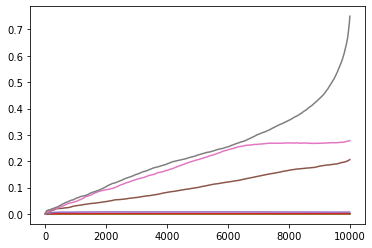

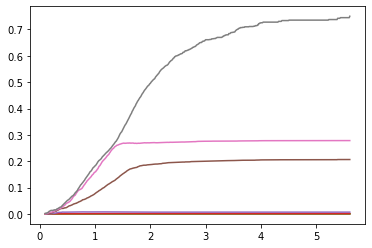

In [3]:
#Plot the radii vs eigvalues value for a center point
cid = 5000
radii, numPoints_list, eigval_list, eigvec_list = eigen_calc_from_dist_mat_withNumPoints(Patches, dist_mat, cid, radint = .01)
rmin = radii[0]
rmax = radii[-1]
eigen_plot_numPoints(eigval_list, numPoints_list)
eigen_plot(eigval_list, radii,rmin, rmax)

In [4]:
from combined_mls_pca import mls_pca
from PatchExtractTools import fnameFix

In [5]:
def SaveLocalPCAs(cloud, cids, k, dist_mat):
    for cid in cids:
        data = np.array(mls_pca(cloud, cid, k, radint = .01, iter=False, dist=dist_mat), dtype=object)
        fn = 'mls_pca_natural_images_data\cid=' + fnameFix(str(cid))
        #np.save(fn, data)
        
#select random center points
num_cids = 1
cids = np.random.choice(np.arange(Patches.shape[0]), size=num_cids)
#intrinsic dimensionality
k = 2
#save ensembles of hyperplanes
SaveLocalPCAs(Patches, cids, k, dist_mat)



(563, 8)
(563, 2, 8)
(563,)
()
()
(9993, 8)
(563, 6, 8)


In [1]:
import os
from manifold_utils.iga import iga

In [13]:
#prune the eigvecs and use those to get average hyperplanes. 
def GrassmannAvg():
    dirName = 'mls_pca_natural_images_data'
    listdirNames = os.listdir(dirName)
    G_hyperplanes = []
    cids = []
    for fn in listdirNames:
        #read a sample data
        filename = dirName + '\\' + fn
        eigval_list, top_eigvecs, new_radii, R_min, R_max, X_mat, bottom_eigvecs = np.load(filename, allow_pickle=True)    
        #record center id
        cids.append(int(fn[4:-4]))
        #find indices for Rmax and Rmin
        R_min_index, R_max_index = np.searchsorted(new_radii, np.array([R_min, R_max]))
        #Take only the top_eigvecs between R_min and R_max
        pruned_top_eigvecs = np.transpose(top_eigvecs[R_min_index:R_max_index], axes=(0,2,1))    
        #Grassmann averaged hyperplanes in dimension N-by-d. For natural images, 8x2.
        G_hyperplanes.append(iga(pruned_top_eigvecs))
    G_hyperplanes = np.array(G_hyperplanes)
    cids = np.array(cids)
    return cids, G_hyperplanes                            

In [14]:
cids, G_hyperplanes = GrassmannAvg() 

In [37]:
np.savez("GrassmannAvg", cids, G_hyperplanes)

In [3]:
from manifold_utils.transition_maps import len_shortest_path

In [7]:
def allPairsHeuristic(Patches, cids, GH):
    '''
    Compute Heuristic for all pairs 
    cid: id of the center points
    GH: Grassmann hyperplanes
    '''
    #heuristic matrix
    n = len(cids)
    hs = np.zeros((n,n))
    for i in range(n):
        #extract i-th cid point
        p_i = Patches[cids[i]]
        #extract i-th cid Grassmann average hyperplanes
        GH_i = GH[i]
        for j in range(i+1, n):
            GH_j = GH[j]
            p_j = Patches[cids[j]]
            #compute heuristic and update 
            h = len_shortest_path(p_i, GH_i, p_j, GH_j)
            #print(p_i, p_j, GH_i, GH_j, h)
            hs[i,j] = h
            hs[j,i] = h
    return hs
            
cids= np.load('GrassmannAvg.npz')['arr_0']  
G_hyperplanes = np.load('GrassmannAvg.npz')['arr_1']  
hs = allPairsHeuristic(Patches, cids, G_hyperplanes)

In [5]:
import matplotlib.pyplot as plt

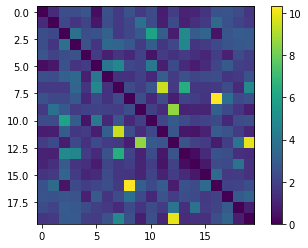

In [9]:
plt.imshow(hs, cmap='viridis')
plt.colorbar()
plt.show()

(array([0.03972421, 0.05766417, 0.11532835, 0.19413605, 0.27742875,
        0.32227866, 0.34982932, 0.33573363, 0.29152443, 0.23321955,
        0.21271673, 0.15825612, 0.09931052, 0.09674767, 0.07047843,
        0.07816699, 0.0390835 , 0.04356849, 0.03139494, 0.02178424,
        0.02242496, 0.01665854, 0.01729925, 0.01281426, 0.00640713,
        0.00832927, 0.00640713, 0.00448499, 0.00448499, 0.0051257 ,
        0.00448499, 0.00256285, 0.00320357, 0.00384428, 0.00128143,
        0.00192214, 0.        , 0.00192214, 0.00128143, 0.00128143,
        0.00064071, 0.00192214, 0.        , 0.        , 0.00128143,
        0.00064071, 0.        , 0.        , 0.        , 0.        ,
        0.00064071, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00064071, 0.00128143, 0.00064071, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00064071, 0.  

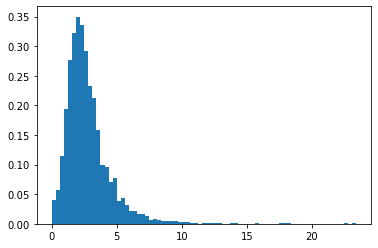

In [15]:
plt.hist(hs.reshape(10000,1), bins=75, density=True)

(array([0.0124, 0.0304, 0.0664, 0.127 , 0.2136, 0.3142, 0.4234, 0.5282,
        0.6192, 0.692 , 0.7584, 0.8078, 0.8388, 0.869 , 0.891 , 0.9154,
        0.9276, 0.9412, 0.951 , 0.9578, 0.9648, 0.97  , 0.9754, 0.9794,
        0.9814, 0.984 , 0.986 , 0.9874, 0.9888, 0.9904, 0.9918, 0.9926,
        0.9936, 0.9948, 0.9952, 0.9958, 0.9958, 0.9964, 0.9968, 0.9972,
        0.9974, 0.998 , 0.998 , 0.998 , 0.9984, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988,
        0.999 , 0.9994, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9998, 0.9998, 1.    ]),
 array([ 0.        ,  0.31215222,  0.62430445,  0.93645667,  1.24860889,
         1.56076112,  1.87291334,  2.18506557,  2.49721779,  2.80937001,
         3.12152224,  3.43367446,  3.74582668,  4.05797891,  4.37013113,
         4.68228336,  4.99443558,  5.3065878 ,  5.61874003,  5.93089225,
         6.24304447,  6.55

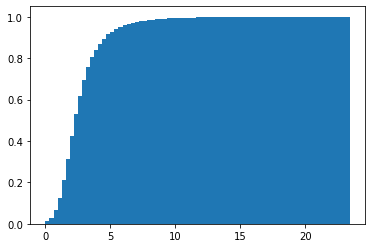

In [16]:
plt.hist(hs.reshape(10000,1), bins=75, density=True, cumulative=True)